# 1. Interpreting u0 (in-situ pore pressure) from CPT data

#### Import Used Libraries

In [1]:
from os import walk
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import pandas as pd
from scipy.signal import argrelextrema

from utils import behaviourindex_pcpt_nonnormalised


Define a utility function

In [2]:
def cost_MSE(y_true, y_pred, a = 0):
    '''
    Cost function

    '''
    # Shape of the dataset
    n = y_true.shape[0]
    
    # Error 
    error = y_true - y_pred
    
    # Compute the sign part of the loss function
    signs = np.sign(error) + a

    return np.dot(np.multiply(error, error), np.multiply(signs, signs)) / n


## 1.1 Finding Existing Data that has u0 documented
Statens vegvesen (Norwegian Public Roads Administration) publishes a standard CPT interpretation workbook (https://www.vegvesen.no/fag/teknologi/geofag/geoteknikk/cptu/). 

This segment of the script looks through the downloaded NADAG dataset and looks for these files to read data from.

### 1.1.1 Search dataset for all ".xlsm" files

Point to the path where the NADAG Data is stored

In [3]:
path = r"C:\Users\User1\Documents\NADAG DATA"

Find all ".xlsm" files

In [4]:
xlsm_files = []
for dirpath, dirnames, filenames in walk(path):
    xlsm_files.extend(
        join(dirpath, f) for f in filenames if ".xlsm" in f.lower()
    )
print("Found",len(xlsm_files),"files")

Found 279 files


### 1.1.2 Read, clean, and plot data

In [5]:
dicts = []
for file in xlsm_files: # TODO: Remove this list index
    print(file)
    if ".pdf" not in file:
        try:
            wb = openpyxl.load_workbook(file, data_only=True)
            print(file)
            names = wb.sheetnames
            print(names)
        except Exception:
            continue
        if "Beregn" in names:
            generelt = wb['Generelt']
            borenr = generelt.cell(row = 8, column = 3).value
            if borenr is None:
                borenr = generelt.cell(row = 8, column = 4).value
            if borenr is None:
                continue
            beregn = wb['Beregn']
            max_row = beregn.max_row
            z = []
            qc = []
            fs = []
            u2 = []
            u0 = []
            temp = []

            for row in range(max_row-19):
                i = row+20
                z.append(beregn.cell(row = i, column = 1).value)
                qc.append(beregn.cell(row = i, column = 2).value)
                fs.append(beregn.cell(row = i, column = 3).value)
                u2.append(beregn.cell(row = i, column = 4).value)
                temp.append(beregn.cell(row = i, column = 6).value)
                u0.append(beregn.cell(row = i, column = 20).value)
            
            dicts.append(
                {
                "prosjket_id":file.split("\\")[5],
                "borenr":borenr,
                "z":z,
                "qc":qc,
                "fs":fs,
                "u2":u2,
                "temp":temp,
                "u0":u0,
                }
            )
df = pd.DataFrame.from_dict(dicts)
df = df[df["borenr"]!=None]

C:\Users\User1\Documents\NADAG DATA\0f67cb2a-b359-43fc-bfde-ebc652d8d98c\E39 Flatoy Borelogg B.xlsm Fra 9.12.19-NO-GRU-03-NO-GRU-03.pdf
C:\Users\User1\Documents\NADAG DATA\121da6f9-5450-4e7e-9990-99ae95efa39f\1673 Afry Rotnes skole, Nittedal\Rapport 1673 Afry Rotnes skole, Nittedal.xlsm


c:\Users\lfabbri\AppData\Local\miniconda3\envs\rockmech_202301\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
c:\Users\lfabbri\AppData\Local\miniconda3\envs\rockmech_202301\lib\site-packages\openpyxl\reader\drawings.py:63: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)


C:\Users\User1\Documents\NADAG DATA\121da6f9-5450-4e7e-9990-99ae95efa39f\1673 Afry Rotnes skole, Nittedal\Rapport 1673 Afry Rotnes skole, Nittedal.xlsm
['Borlogg', 'Administrasjon', 'Målebrev', 'Tap', 'Instruksjoner']
C:\Users\User1\Documents\NADAG DATA\15dc4951-f2c1-4040-a3d2-fe5105aa5221\Tolkningsark CPTU-rev05 Test BP23.xlsm
C:\Users\User1\Documents\NADAG DATA\15dc4951-f2c1-4040-a3d2-fe5105aa5221\Tolkningsark CPTU-rev05 Test BP23.xlsm
['Oversikt revisjoner', 'Tolkningsark', 'LAB', 'PLOTT', 'Beregning plott', 'Input rådatafil', 'Klassifisering', 'Resistivitet', 'Lab. beregning', 'Romvekt-manuelt', 'IP-manuelt', 'OCR-manuelt', 'Poretrykk-manuelt']
C:\Users\User1\Documents\NADAG DATA\15dc4951-f2c1-4040-a3d2-fe5105aa5221\Tolkningsark CPTU-rev05 Test BP23_versjon 2.xlsm
C:\Users\User1\Documents\NADAG DATA\15dc4951-f2c1-4040-a3d2-fe5105aa5221\Tolkningsark CPTU-rev05 Test BP23_versjon 2.xlsm
['Oversikt revisjoner', 'Tolkningsark', 'LAB', 'PLOTT', 'Beregning plott', 'Input rådatafil', 'Klas

c:\Users\lfabbri\AppData\Local\miniconda3\envs\rockmech_202301\lib\site-packages\openpyxl\reader\workbook.py:120: UserWarning: Print area cannot be set to Defined name: Borelogg!$A:$T.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
c:\Users\lfabbri\AppData\Local\miniconda3\envs\rockmech_202301\lib\site-packages\openpyxl\reader\workbook.py:120: UserWarning: Print area cannot be set to Defined name: 'Miljøprøvetaking land'!$A:$K.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
c:\Users\lfabbri\AppData\Local\miniconda3\envs\rockmech_202301\lib\site-packages\openpyxl\reader\workbook.py:120: UserWarning: Print area cannot be set to Defined name: 'Miljøprøvetaking sjø'!$A:$J.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


Feltarbeider
Lab-arbeider
Rapportering og adm
C:\Users\User1\Documents\NADAG DATA\1837c05e-b0e1-46be-855c-50ae24193b39\Borelogg 5174408_2017-08-07 del 1.xlsm
['Borelogg', 'Feltkommentarer', 'Borekort', 'Borekort n33', 'Borekort n34', 'Borekort n32', 'Borekort n31', 'Borekort n30', 'Borekort n29', 'Borekort n28', 'Borekort n27', 'Borekort n26', 'Borekort n25', 'Borekort n24', 'Borekort n23', 'Borekort n22', 'Borekort n21', 'Borekort n20', 'Borekort n19', 'Borekort n46', 'Borekort n18', 'Borekort n16', 'Borekort n15', 'Borekort n14', 'Borekort n7', 'Borekort n44', 'Borekort n45', 'Borekort n17', 'Borekort n13', 'Borekort n9', 'Borekort n10', 'Borekort n8', 'Borekort n6', 'Borekort n5', 'Borekort n4', 'Borekort n3', 'Borekort n11', 'Borekort n12', 'Borekort n1', 'Borekort N2', 'Prøvekort', 'Naver n27', 'Naver n25', 'Naver n20', 'Naver n45', 'Naver n44', 'Naver n7', 'Naver n15', 'Naver n10', 'Naver n1', 'CPTukort', 'CPTukort n25', 'CPTukort n22', 'CPTukort n44', 'CPTukort n7', 'CPTukort n1

c:\Users\lfabbri\AppData\Local\miniconda3\envs\rockmech_202301\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


C:\Users\User1\Documents\NADAG DATA\18710c2d-e9a3-41dc-b2b2-a8b68dbd6506\CPTu 05.xlsm
['Generelt', '1.Måledata', '2.Spenn.', '3.Profil', '4.Avledede', '5.Cu', '6.a-φ', '7.M', '8.OCR', "9.σ'c", '10.Dr', '11.N fakt', '12.St', '13.w & Ip', '14.ADP', '15. Diss', "16.Rob'90", "17.Rob'86", "18.Esl'00", "19.Sen'89", "20.Scn'12", "21.NIFS'15", "22.NIFS'14", "23.Rob'16", "24.Val'17", "25.SVV'18_A", "26.SVV'18_B", '27.Q', '28.F', '29.U', '30.v', '31.Res', 'LAB', 'Beregn', 'Interp', 'Klass', '3DKlass', 'kNNKlass', 'Data inn', 'Lab inn', 'diss_saml', 'Sertifikater', 'SGF-koder', '2D klass-metoder', '3D klass-metoder', 'kNN klass-metoder', 'diss_beregn_mal', 'Versjon', 'Referanser']
C:\Users\User1\Documents\NADAG DATA\18710c2d-e9a3-41dc-b2b2-a8b68dbd6506\CPTu 2019_031.xlsm
C:\Users\User1\Documents\NADAG DATA\18710c2d-e9a3-41dc-b2b2-a8b68dbd6506\CPTu 2019_031.xlsm
['Generelt', '1.Måledata', '2.Spenn.', '3.Profil', '4.Avledede', '5.Cu', '6.a-φ', '7.M', '8.OCR', "9.σ'c", '10.Dr', '11.N fakt', '12.St',

c:\Users\lfabbri\AppData\Local\miniconda3\envs\rockmech_202301\lib\site-packages\openpyxl\reader\workbook.py:120: UserWarning: Print area cannot be set to Defined name: Borekort!$A:$J.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
c:\Users\lfabbri\AppData\Local\miniconda3\envs\rockmech_202301\lib\site-packages\openpyxl\reader\workbook.py:120: UserWarning: Print area cannot be set to Defined name: 'Bestilling lab'!$A:$AG.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


Feltarbeider
Lab-arbeider
Rapportering og adm
C:\Users\User1\Documents\NADAG DATA\9a7128d2-81d2-473c-ade1-b2bc6f5d2d52\Borelogg 2019.xlsm
['Oversikt', 'Borekort', 'Bestilling lab', 'Sammendrag', 'Feltarbeider', 'Lab-arbeider', 'Rapportering og adm', 'Hjelp']
C:\Users\User1\Documents\NADAG DATA\9b31cbc2-ead0-4860-a1eb-a58774f85726\Boredagbok - 21016 Torridalsveien.xlsm
C:\Users\User1\Documents\NADAG DATA\9b31cbc2-ead0-4860-a1eb-a58774f85726\Boredagbok - 21016 Torridalsveien.xlsm
['Oppdragsinfo', 'Totalsonderinger', 'Trykksonderinger', 'Prøvetakning', 'Poretrykksmåler (EL)', 'Poretrykksmåler (hydraulisk)', 'Formler']
C:\Users\User1\Documents\NADAG DATA\a229dcb7-b77a-4f91-b957-d1263de5ada5\5161185 Melmoen Grong Borelogg_3.xlsm
Feltarbeider
Lab-arbeider
Rapportering og adm
C:\Users\User1\Documents\NADAG DATA\a229dcb7-b77a-4f91-b957-d1263de5ada5\5161185 Melmoen Grong Borelogg_3.xlsm
['Borekort N2', 'Borekort N3', 'Borekort N5', 'Borekort N4', 'Borekort N1', 'Borelogg', 'Feltkommentarer', 'P

c:\Users\lfabbri\AppData\Local\miniconda3\envs\rockmech_202301\lib\site-packages\openpyxl\reader\workbook.py:120: UserWarning: Print area cannot be set to Defined name: Borelogg!$A:$U.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


Feltarbeider
Lab-arbeider
NGF - Feltarbeider
Rapportering og adm
C:\Users\User1\Documents\NADAG DATA\a5db3cf8-fef7-4158-bf25-ae7ac9f8cd4d\Copy of Borelogg Klovningen.xlsm korrigert.xlsm
['Info', 'Borelogg', 'NGF - Feltarbeider', 'Feltkommentarer', 'Borekort', 'Borekort BH05', 'Borekort BH02', 'Borekort BH04', 'Borekort BH06', 'Borekort BH07', 'Borekort BH08', 'Borekort BH09', 'Borekort BH16', 'Borekort BH01', 'Borekort BH15', 'Borekort BH14', 'Borekort BH03', 'Borekort BH10', 'Borekort BH11', 'Borekort BH12', 'Prøve BH03', 'Prøve BH04', 'Prøve BH01', 'CPTukort', 'Piezometerkort', 'Miljøprøvetaking sjø', 'Miljøprøvetaking land', 'Miljøbrønn', 'Mengder', 'Feltarbeider', 'Lab-arbeider', 'Rapportering og adm', 'Sammendrag', 'Oppdragsvilkår', 'Bruksanvisning']
C:\Users\User1\Documents\NADAG DATA\aa454fdf-87ad-4a7f-a1a2-79bf7e5d4497\GU Arna stasjon 28.05.2019 T.T.XLSM
C:\Users\User1\Documents\NADAG DATA\aa454fdf-87ad-4a7f-a1a2-79bf7e5d4497\GU Arna stasjon 28.05.2019 T.T.XLSM
['Borelogg', 'Pr

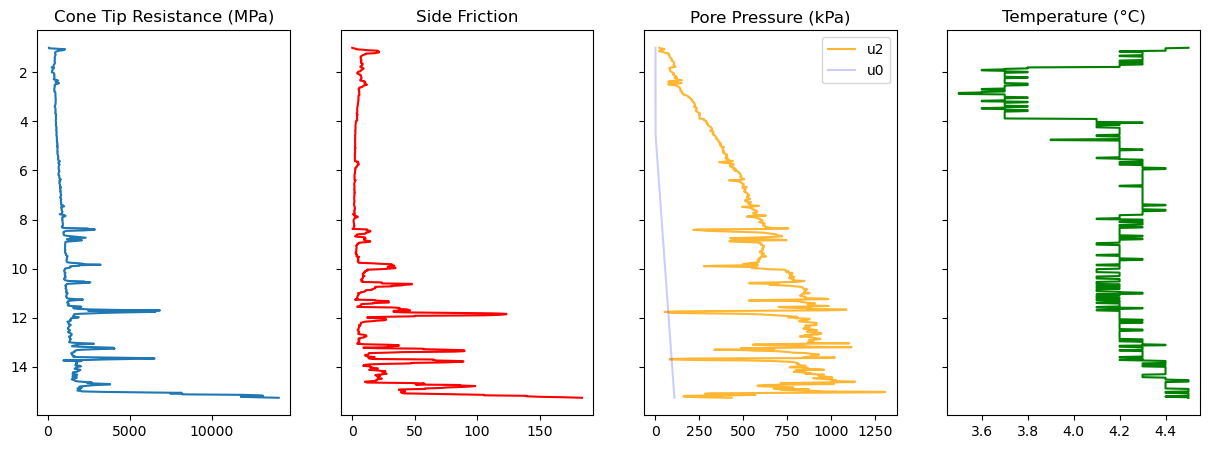

In [6]:
data = df.iloc[0]

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(15, 5))

axs[0].invert_yaxis()

axs[0].plot(data["qc"], data["z"])
axs[0].set_title("Cone Tip Resistance (MPa)")

axs[1].plot(data["fs"], data["z"], c="red")
axs[1].set_title("Side Friction")

axs[2].plot(data["u2"], data["z"], c="orange", alpha=0.8, label="u2")
axs[2].plot(data["u0"], data["z"], c="blue", alpha=0.2, label="u0")

axs[2].legend()
axs[2].set_title("Pore Pressure (kPa)")

axs[3].plot(data["temp"],data["z"], c = "green")
axs[3].set_title("Temperature (°C)")

plt.show()

## 1.2 Interpreting in-situ pore pressure from CPTu data without dissipation tests or other measurement of pore pressure.

**Motivation: Interpret pore pressure from CPT readings**

The CPT data downloaded from NADAG is often not obviously associated with pore pressure data or water table readings. Therefore, in order to use normalized parameters to make interpretations from the CPT data, pore pressure data is needed from somewhere else.

CPTs contain pore pressure sensors, however during pressing of the cone, the measured pore pressure can deviate from the in-situ pore pressure due to properties of the soil (excess or negative pore pressures in contractive or dilative soils). 

Dissipation tests where the cone is stopped and pore pressure is allowed to dissipate are often used to measure in-situ pore pressure. If the soil was sufficently free draining, the pore pressure sensor would thus read close to the correct in-situ pressure during pressing. The aim of this exersize is to attempt to predict in-situ pore pressures and evaluate that prediction.

## 1.2.1 Assume water table at 2 m below 0 depth as baseline

To establish a baseline for evaluation of preformance of any method of estimating pore pressure on CPTu data, we can start by making a simple assumption. What seems to work best is assuming the water table is 2 m below the ground surface, which results in a median RMSE of ~10 kPa, or 1 m of head - not too bad.

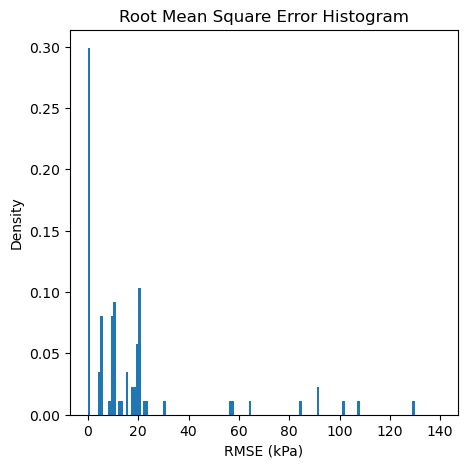

Median error: 9.93 Average error: 18.62 Max error: 150.45


In [19]:
WATER_WEIGHT = 10
errors = []
for _, data in df.iterrows():
    if data.borenr is None:
        continue

    depth = np.asarray(data['z'])
    
    depth = depth - 2

    depth[depth<0] = 0

    u0_pred = depth*WATER_WEIGHT

    errors.append((cost_MSE(np.asarray(data["u0"]),np.asarray(u0_pred)))**0.5)
    
_, ax = plt.subplots(figsize = (5,5))

errors = np.asarray(errors)
ax.hist(errors, bins=140, range = [0,140], density=True)
ax.set_title("Root Mean Square Error Histogram")
ax.set_xlabel("RMSE (kPa)")
ax.set_ylabel("Density")
plt.show()

print("Median error:", round(np.median(errors),2), "Average error:", round(np.mean(errors),2), "Max error:", round(np.max(errors),2))

### 1.2.2 Function to fit hydrostatic pressure to measured lows in u2
As seen in the plots in section 1.1.2 u0 is often close to u2 when the pore pressure drops to a low (interpreted as entering a free draining layer after being in a layer where excess pore water pressure is generated).
The below function aims to fit a hydrostatic pore pressure distribution to the lowest portions of the pore pressure data that best match a hydrostatic distribution.

The functions are defined below for clarity, but are functions contained within utils.

The fit function combines a weighted mean squared error that penalizes overestimating, and a score based on how often the estimate is within a threshold.

It combines both components of the scores array by multiplying them element-wise. This gives a single score for each trial value that hopefully balances not overestimating (and missing pore pressure low points where pore pressure dissipates), and fitting well.


In [8]:
WATER_WEIGHT = 10

def cost_MSE(y_true, y_pred, a = 0):
    '''
    Cost function

    '''
    # Shape of the dataset
    n = y_true.shape[0]
    
    # Error 
    error = y_true - y_pred
    
    # Compute the sign part of the loss function
    signs = np.sign(error) + a

    return np.dot(np.multiply(error, error), np.multiply(signs, signs)) / n

def u0_fit_score(
    u2_df: pd.DataFrame,
    Y_pred: np.ndarray,
    pore_pressure_name: str = "measured_pore_pressure",
    depth_name: str = "depth",
    neg_multiplier: float = -0.6269,
    step_criteria: float = 1.728,
) -> list:
    """Calculates the fit score and the cost of the predicted pore pressure values against the measured ones.

    Args:
        u2_df: A data frame containing the measured pore pressure values and the depth values.
        Y_pred: An array containing the predicted pore pressure values.
        neg_multiplier: A factor to adjust the penalty for overestimatng the pore pressure. The default is -0.7.
        pore_pressure_name: The name of the column in u2_df that contains the measured pore pressure values. The default is "measured_pore_pressure".
        depth_name: The name of the column in u2_df that contains the depth values. The default is "depth".
        step_criteria: A threshold to determine if the difference between the predicted and measured pore pressure values is acceptable. The default is 0.5.

    Returns:
        A list containing two elements: the fit score and the cost. The fit score is a percentage that indicates how many of the predicted values are within the step criteria of the measured values, adjusted by the median of the differences. The cost is a mean squared error between the predicted and measured values, with a higher penalty for underestimating the pore pressure.
    """
    test = np.asarray(u2_df[pore_pressure_name])
    Y_pred = np.asarray(Y_pred)
    df = pd.DataFrame(test, columns=["u2"])
    df["depth"] = u2_df[depth_name]
    df["Y_pred"] = Y_pred
    df["diff"] = Y_pred - test

    cost = cost_MSE(test, Y_pred,a = neg_multiplier)
    
    # df = df[df["Y_pred"]!= 0]

    test = df["u2"].to_numpy()
    Y_pred = df["Y_pred"].to_numpy()
    
    

    df["diff"][df["diff"] < 0] = df["diff"][df["diff"] < 0] * neg_multiplier

    abs_diff = np.absolute(df["diff"])
    diff_in_criteria = abs_diff[abs_diff<step_criteria]
    if len(diff_in_criteria) == 0:
        median_in = 0
    else:
        median_in = (np.median(diff_in_criteria))-1

    length = df["depth"].max() - df["depth"].min()


    return [((len(diff_in_criteria)/(1-median_in))*100)/length,cost], (Y_pred, test, df["depth"].to_numpy())


def fit_u0(
    u2_df,
    trial_interval=0.1,
    plot=False,
    water_weight=WATER_WEIGHT,
    depth_name="depth",
    pore_pressure_name="measured_pore_pressure",
    neg_multiplier: float = -0.6269,
    step_criteria: float = 1.728,
    return_score = False,
):
    """ Finds the best estimate of u0 (water pressure at the surface) by minimizing the mean
    absolute difference between predicted and measured pore pressure utilizing a factor to penalize negative differences.

    Args:
        u2_df: A dataframe with columns named 'depth' and 'measured_pore_pressure'.
        trial_interval: The interval to try different values where the groundwater table is. Defaults to 0.1.
        plot: Whether to plot the scores for different values of u0. Defaults to False.
        water_weight: The weight of water in kPa/m. Defaults to WATER_WEIGHT.
        depth_name: The name of the column with depth data. Defaults to "depth".
        pore_pressure_name: The name of the column with measured pore pressure data. Defaults to "measured_pore_pressure".
        neg_multiplier: A factor to penalize negative differences. Defaults to -0.95.

    Returns:
        A series of predicted pore pressure values using the best estimate of u0.
    """
     
    depth_array = np.asarray(u2_df[depth_name])
    max_depth = depth_array.max()
    trials = np.arange(0, max_depth, trial_interval)
    scores = []
    for trial in trials:
        depth_below_water = depth_array - trial
        depth_below_water[depth_below_water < 0] = 0
        u0_pred = depth_below_water * water_weight
        score, _ = u0_fit_score(
            u2_df,
            u0_pred,
            pore_pressure_name=pore_pressure_name,
            neg_multiplier=neg_multiplier,
            depth_name = depth_name,
            step_criteria = step_criteria
        )
        scores.append(score)
    scores = np.asarray(scores)
    
    normalized_good_fit = scores[:,0]/np.mean(scores[:,0])
    # normalized_good_fit = normalized_good_fit/normalized_good_fit.max()
    normalized_abs_diff = (1/scores[:,1])/(1/scores[:,1]).max()


    scores = normalized_good_fit*normalized_abs_diff

    scores = list(scores)
    index_mins = scores.index(max(scores))

    depth_below_water = depth_array - trials[index_mins]
    depth_below_water[depth_below_water < 0] = 0

    if plot:
        _, axs2 = plt.subplots(1,2, figsize=(8, 3))

        axs2[0].plot(trials, scores, label = "Final Score")
        axs2[0].plot(trials, normalized_good_fit, label = "Within Threshold Score", alpha = 0.2)
        axs2[0].plot(trials, normalized_abs_diff, label = "Adjusted MSE", alpha = 0.2)
        axs2[0].legend()
        #if len(minima[0]) > 0:
        if index_mins:
            axs2[0].set_xlabel("Trial groundwater table location (m)")
            axs2[0].set_ylabel("Fit score (-)")
            axs2[0].set_title(
                "Fit of Trial Depths. \n Max marked with 'x' represents best trial"
            )
            axs2[0].plot(trials[index_mins], scores[index_mins], "x")
            
            _, out = u0_fit_score(
                                    u2_df,
                                    depth_below_water * water_weight,
                                    pore_pressure_name=pore_pressure_name,
                                    neg_multiplier=neg_multiplier,
                                    depth_name = depth_name,
                                  )

            axs2[1].set_xlabel("Pore Pressure (kPa)")
            axs2[1].set_ylabel("Depth (m)")
            axs2[1].plot(out[0],out[2],label = "U2 Measurement",linestyle=(0, (5, 10)))
            axs2[1].plot(out[1],out[2], alpha = 0.2,label = "U0 Prediction")
            axs2[1].invert_yaxis()
            axs2[1].legend()
            
    if return_score:
        return (depth_below_water*water_weight), max(scores)
    return depth_below_water * water_weight


The below graphs demonstrate how the scores look, and how varying the negative weighting factor changes the result.


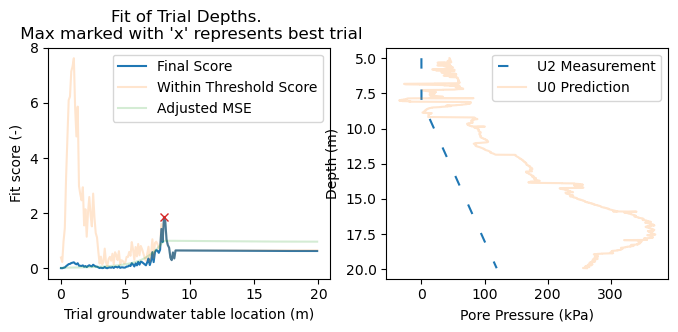

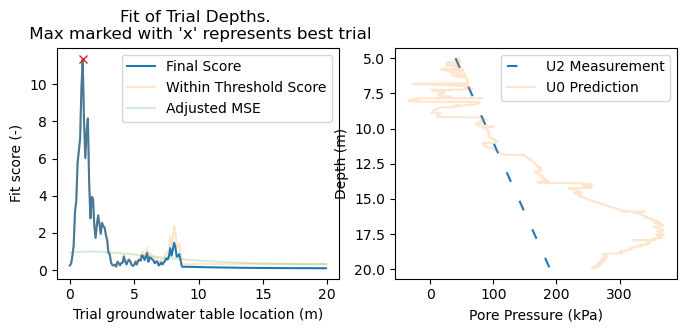

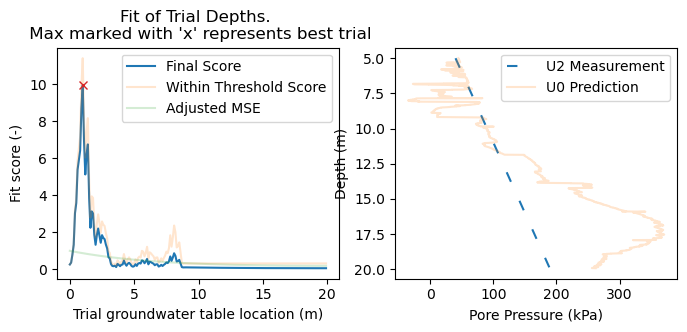

In [9]:
for i in [-.99,-0.5, 0.5]:

    u_pred = fit_u0(
            df.iloc[8],
            plot = True,
            trial_interval=0.1,
            depth_name="z",
            pore_pressure_name="u2",
            neg_multiplier=i,
        )

The below graph shows the CPTu data, along with the scores for different trial groundwater table depths.

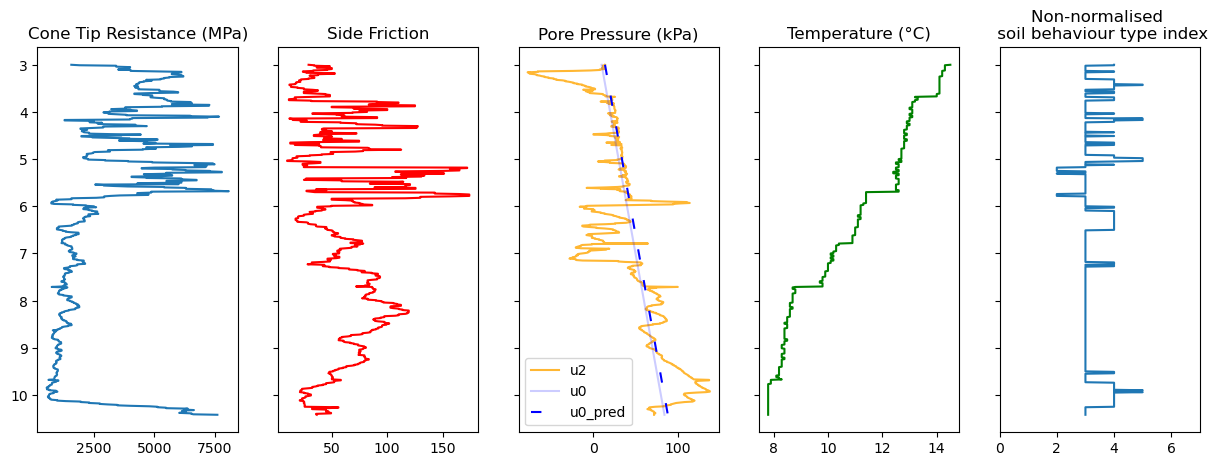

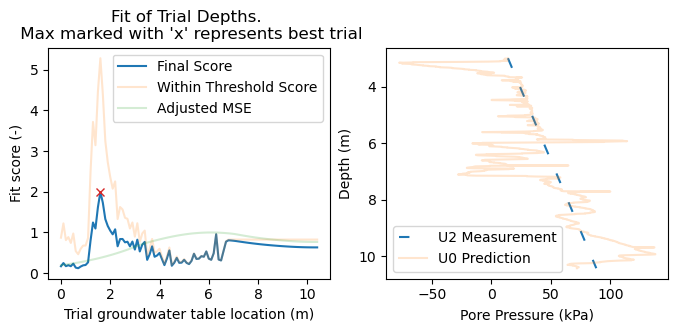

In [10]:
vec_behavioir_index = np.vectorize(behaviourindex_pcpt_nonnormalised)
for _, data in df.loc[3:4].iterrows():#df.iterrows():#
    if data.borenr is None:
        continue
    fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15, 5))

    axs[0].invert_yaxis()

    axs[0].plot(data["qc"], data["z"])
    axs[0].set_title("Cone Tip Resistance (MPa)")

    axs[1].plot(data["fs"], data["z"], c="red")
    axs[1].set_title("Side Friction")

    axs[2].plot(data["u2"], data["z"], c="orange", alpha=0.8, label="u2")
    axs[2].plot(data["u0"], data["z"], c="blue", alpha=0.2, label="u0")

    u0_pred = fit_u0(
        data,
        plot = True,
        trial_interval=0.1,
        depth_name="z",
        pore_pressure_name="u2",
        neg_multiplier = -0.6269,
        step_criteria = 1.728,
    )
    
    axs[2].plot(u0_pred, data["z"], c="blue", label="u0_pred", linestyle=(0, (5, 10)))
    axs[2].legend()
    axs[2].set_title("Pore Pressure (kPa)")

    axs[3].plot(data["temp"],data["z"], c = "green")
    axs[3].set_title("Temperature (°C)")

    soil_type = vec_behavioir_index(np.asarray(data.qc), np.asarray(data.fs))

    axs[4].plot(soil_type, data["z"])
    axs[4].set_title("Non-normalised \n soil behaviour type index")
    axs[4].set_xlim((0, 7))
    plt.show()
    break

To experiment with different values, a function to score the fit of the predicted u0 is defined, and Bayesian Optimization is used to find good values for the negative multplier ant the threshold for the closeness score.

The best result was a MSE of 264 (or a RMSE of 16), which on average means that the median estimate for the water table derived from this method varies by about 1.5 m from what is noted in the CPTu spreadsheet... which is ok, but worse than just assuming the water table is at 2 m.

In [11]:
def score_neg_mult_and_step_criteria(neg,step):
    scores = []
    for _, data in df.iterrows():
        if data.borenr is None:
            continue

        u0_pred = fit_u0(
            data,
            plot = False,
            trial_interval=0.1,
            depth_name="z",
            pore_pressure_name="u2",
            neg_multiplier=neg,
            step_criteria = step
        )

        scores.append(cost_MSE(np.asarray(data["u0"]),np.asarray(u0_pred)))
    return np.median(np.asarray(scores))*-1

In [12]:
from bayes_opt import BayesianOptimization, UtilityFunction
import warnings

warnings.filterwarnings('ignore')

# Bounded region of parameter space
pbounds = {'neg': (-0.999, 0.999), 'step': (0, 5)}

optimizer = BayesianOptimization(
    f=score_neg_mult_and_step_criteria,
    pbounds=pbounds,
    random_state=1,
)

acquisition_function = UtilityFunction(kind="ucb", kappa=3)

optimizer.probe(
    params={"neg": -0.95, "step": 0.5},
    lazy=True,
)

optimizer.probe(
    params={"neg": -0.6269, "step": 1.728},
    lazy=True,
)

optimizer.maximize(
    init_points=10,
    n_iter=10,
    acquisition_function = acquisition_function
)

print(optimizer.max)


|   iter    |  target   |    neg    |   step    |
-------------------------------------------------
| 1         | -400.0    | -0.95     | 0.5       |
| 2         | -342.5    | -0.6269   | 1.728     |
| 3         | -360.8    | -0.1658   | 3.602     |
| 4         | -590.1    | -0.9988   | 1.512     |
| 5         | -264.1    | -0.7058   | 0.4617    |
| 6         | -342.5    | -0.6269   | 1.728     |
| 7         | -400.0    | -0.2063   | 2.694     |
| 8         | -316.2    | -0.1614   | 3.426     |
| 9         | -375.4    | -0.5905   | 4.391     |
| 10        | -379.3    | -0.9443   | 3.352     |
| 11        | -361.0    | -0.1652   | 2.793     |
| 12        | -289.0    | -0.7185   | 0.9905    |
| 13        | -360.8    | -0.6126   | 0.666     |
| 14        | -278.0    | -0.5914   | 0.3162    |
| 15        | -324.0    | -0.772    | 0.2438    |
| 16        | -361.0    | -0.4908   | 1.113     |
| 17        | -269.0    | -0.3639   | 0.4107    |
| 18        | -278.0    | -0.3048   | 0.1773    |


To look further into the results, a histogram of the RMSE for each individual CPTu is plotted, as well as a scatter plot of the RMSE vs the Fit Score. 

I was hoping that the quality of the result could be discerned by the fit score, but that doesnt seem to be the case.

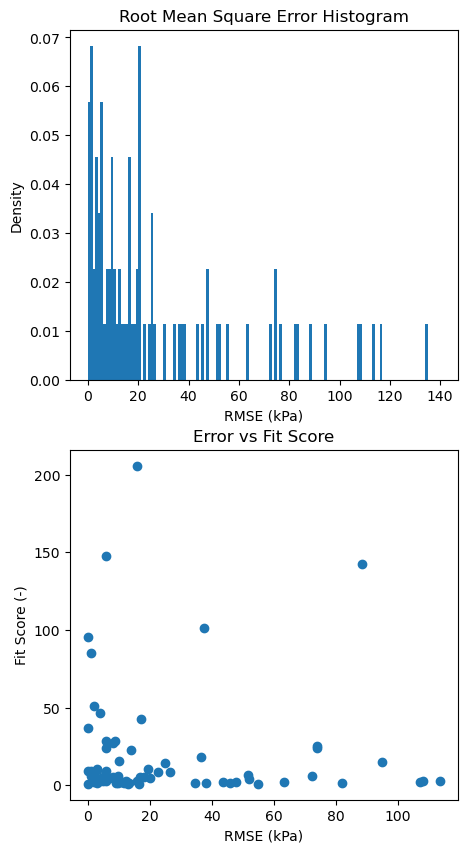

Median error: 16.25 Average error: 28.05 Max error: 134.0


In [20]:
def plot_distribution_MSE(neg,step):
    scores = []
    errors = []
    for _, data in df.iterrows():
        if data.borenr is None:
            continue

        u0_pred, score = fit_u0(
            data,
            plot = False,
            trial_interval=0.1,
            depth_name="z",
            pore_pressure_name="u2",
            neg_multiplier=neg,
            step_criteria = step,
            return_score=True
        )

        scores.append(score)

        errors.append((cost_MSE(np.asarray(data["u0"]),np.asarray(u0_pred)))**0.5)
        
    _, axs = plt.subplots(2,1, figsize = (5,10))#, sharex=True)

    axs[0].hist(np.asarray(errors), bins=140, range = [0,140], density = True)
    axs[0].set_title("Root Mean Square Error Histogram")
    axs[0].set_xlabel("RMSE (kPa)")
    axs[0].set_ylabel("Density")

    axs[1].scatter(np.asarray(errors), np.asarray(scores))

    axs[1].set_xlabel("RMSE (kPa)")
    axs[1].set_ylabel("Fit Score (-)")

    axs[1].set_title("Error vs Fit Score")

    plt.show()

    return errors

errors = plot_distribution_MSE(optimizer.max['params']['neg'],optimizer.max['params']['step'])

print("Median error:", round(np.median(errors),2), "Average error:", round(np.mean(errors),2), "Max error:", round(np.max(errors),2))